In [1]:
import re
from nltk.tokenize.casual import TweetTokenizer
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


Load words embeddings (FastText trained over VK posts)

In [2]:
fasttext = KeyedVectors.load_word2vec_format('embeddings/fasttext_big_300d.vec')
fasttext.most_similar('котейка')

[('котейко', 0.7458697557449341),
 ('Котейка', 0.7427492141723633),
 ('котейки', 0.6791476011276245),
 ('котейкой', 0.6727944612503052),
 ('кошак', 0.6622782945632935),
 ('котэ', 0.6595468521118164),
 ('совушка', 0.658632755279541),
 ('киса', 0.642015278339386),
 ('котейку', 0.633861243724823),
 ('собакадругчеловека', 0.6230987310409546)]

In [3]:
fasttext.most_similar('cat')

[('cats', 0.8391395211219788),
 ('kitten', 0.8023779988288879),
 ('dog', 0.7982020378112793),
 ('kittens', 0.7829532623291016),
 ('pet', 0.7627919912338257),
 ('kitty', 0.7567681074142456),
 ('catsagram', 0.7563411593437195),
 ('catstagram', 0.75223708152771),
 ('petstagram', 0.7464101314544678),
 ('catsofinstagram', 0.7379685640335083)]

Load tweets (https://study.mokoron.com/)

In [2]:
pd.set_option('max_colwidth', -1)

negative = pd.read_csv('data/negative.csv', header=None, sep=';', usecols=[3])
negative['class'] = 0
positive = pd.read_csv('data/positive.csv', header=None, sep=';', usecols=[3])
positive['class'] = 1
df = pd.concat([negative, positive], ignore_index=True, copy=False)
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns={3: 'text'}, inplace=True)
df.head(n=10)

,text,class
0,целую ночь почти не спала!((\nкак я ненавижу болеть!,0
1,"RT @detu_ulic_ZAO: #Детиулиц фестиваль ""Рубеж"" подошел к концу!)Всем участникам СПАСИБО! http://t.co/Se2YxvouAo",1
2,Утром все постеры свалились:(( Такой хуйни я чет не помню:(( http://t.co/Lds8htnQg4,0
3,Я забыла взять с собой что-нибудь покушать.. Я не доживу до окончания лекции((,0
4,Пидармоты (((((( 0:1 сукаааааааа бляяяяяяяяяя,0
5,"Хотелось бы погулять, но отваливающаяся спина немного против :(",0
6,Как залечить душевные раны? — Музыкой) http://t.co/uhxPPe3yRU,1
7,"RT @sufehabuqag: пора бы уже сделать кнопочку типа ""i like"" от фейсбука, только ""i hate"" :)",1
8,пропустила тренировочную по математике( печаль(,0
9,Есть задача для эникейщика — мешать заказчику мешать айтишнику :),1


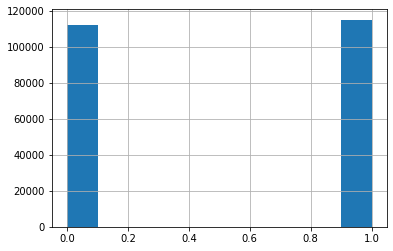

In [3]:
df['class'].hist()

In [4]:
df['class'].value_counts()

1    114911
0    111923
Name: class, dtype: int64

In [5]:
def preprocess_text(text):
    # Lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @ mentions
    text = re.sub(r"@\S+", "", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove rt (retweets)
    text = re.sub("rt", "", text)
    # Remove unneeded symbols
    text = re.sub(r"[/~/`/@/#/$/%/&/-/_/+/,/.]", "", text)
    # Remove extra spaces
    text = re.sub(" +", ' ', text)
    
    return text

In [6]:
df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_text(x))
df.head()

,text,class,preprocessed_text
0,целую ночь почти не спала!((\nкак я ненавижу болеть!,0,целую ночь почти не спала!((\nкак я ненавижу болеть!
1,"RT @detu_ulic_ZAO: #Детиулиц фестиваль ""Рубеж"" подошел к концу!)Всем участникам СПАСИБО! http://t.co/Se2YxvouAo",1,"фестиваль ""рубеж"" подошел к концу!)всем участникам спасибо!"
2,Утром все постеры свалились:(( Такой хуйни я чет не помню:(( http://t.co/Lds8htnQg4,0,утром все постеры свалились:(( такой хуйни я чет не помню:((
3,Я забыла взять с собой что-нибудь покушать.. Я не доживу до окончания лекции((,0,я забыла взять с собой что-нибудь покушать я не доживу до окончания лекции((
4,Пидармоты (((((( 0:1 сукаааааааа бляяяяяяяяяя,0,пидармоты (((((( 0:1 сукаааааааа бляяяяяяяяяя


Split text to train/test

In [7]:
text_train, text_test, label_train, label_test = train_test_split(
    df['preprocessed_text'],
    df['class'],
    test_size=0.2,
    shuffle=True,
    random_state=42
)

Tweet tokenizer

In [8]:
tweet_tokenizer = TweetTokenizer()

Prepare data for BiLSTM

In [11]:
def text_data_to_tokens(texts):
    res = []
    for txt in texts:
        tokenized_txt = tweet_tokenizer.tokenize(txt)
        replaced_by_num = [fasttext.vocab[word].index for word in tokenized_txt if word in fasttext.vocab]
        res.append(replaced_by_num)
    return res

In [12]:
X_train_bilstm = text_data_to_tokens(text_train)
X_test_bilstm = text_data_to_tokens(text_test)
len(X_train_bilstm), len(X_test_bilstm)

(181467, 45367)

The longest sentence length

In [13]:
max([max([len(x) for x in X_train_bilstm]), max([len(x) for x in X_test_bilstm])])

47

Embedding layer params

In [14]:
fasttext.get_keras_embedding().get_config()

{'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 507470,
 'output_dim': 300,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

Some metrics definition

In [15]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

BiLSTM training

In [16]:
maxlen = 64
batch_size = 256
epochs = 30

X_train = sequence.pad_sequences(X_train_bilstm, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test_bilstm, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(label_train)
y_test = np.array(label_test)

model = Sequential()
model.add(fasttext.get_keras_embedding())
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callbacks = [ModelCheckpoint(filepath='trained_models/fasttext_bilstm.h5', 
                             monitor='val_loss', 
                             save_best_only=True)
            ]
model.compile('adadelta', 'binary_crossentropy', metrics=[precision, recall, f1])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.1, 
                    callbacks=callbacks)

X_train shape: (181467, 64)
X_test shape: (45367, 64)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 163320 samples, validate on 18147 samples
Epoch 1/30
163320/163320 [==============================] - 69s 421us/step - loss: 0.3023 - precision: 0.8490 - recall: 0.8748 - f1: 0.8575 - val_loss: 0.2563 - val_precision: 0.8227 - val_recall: 0.9415 - val_f1: 0.8778
Epoch 2/30
163320/163320 [==============================] - 67s 409us/step - loss: 0.2336 - precision: 0.8819 - recall: 0.8864 - f1: 0.8829 - val_loss: 0.2216 - val_precision: 0.8854 - val_recall: 0.8886 - val_f1: 0.8867
Epoch 3/30
163320/163320 [==============================] - 66s 406us/step - loss: 0.2179 - precision: 0.8895 - recall: 0.8901 - f1: 0.8888 - val_loss: 0.2161 - val_precision: 0.8759 - val_recall: 0.9066 - val_f1: 0.8907
Epoch 4/30

Epoch 23/30
163320/163320 [==============================] - 66s 403us/step - loss: 0.1546 - precision: 0.9301 - recall: 0.9271 - f1: 0.9282 - val_loss: 0.2076 - val_precision: 0.8947 - val_recall: 0.9155 - val_f1: 0.9047
Epoch 24/30
163320/163320 [==============================] - 65s 401us/step - loss: 0.1524 - precision: 0.9311 - recall: 0.9284 - f1: 0.9293 - val_loss: 0.2040 - val_precision: 0.8949 - val_recall: 0.9138 - val_f1: 0.9039
Epoch 25/30
163320/163320 [==============================] - 65s 399us/step - loss: 0.1492 - precision: 0.9333 - recall: 0.9306 - f1: 0.9315 - val_loss: 0.2153 - val_precision: 0.9141 - val_recall: 0.8863 - val_f1: 0.8996
Epoch 26/30
163320/163320 [==============================] - 64s 393us/step - loss: 0.1461 - precision: 0.9347 - recall: 0.9318 - f1: 0.9329 - val_loss: 0.2130 - val_precision: 0.9165 - val_recall: 0.8885 - val_f1: 0.9019
Epoch 27/30
163320/163320 [==============================] - 105s 641us/step - loss: 0.1438 - precision: 0.9356 

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         152241000 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 152,428,009
Trainable params: 187,009
Non-trainable params: 152,241,000
_________________________________________________________________


Some plots

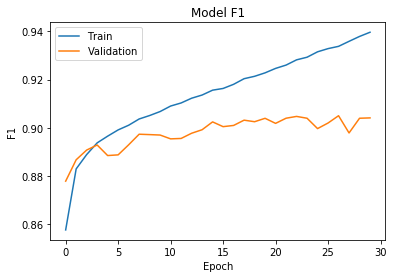

In [17]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

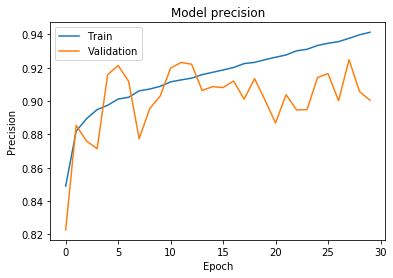

In [18]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

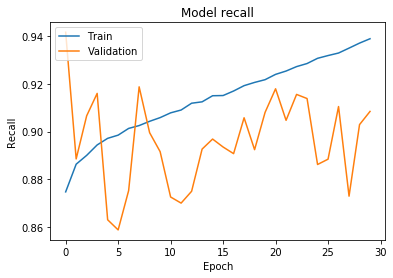

In [19]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

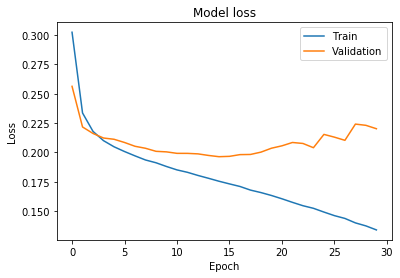

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Test classification report

In [21]:
print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     22473
           1       0.90      0.91      0.91     22894

    accuracy                           0.90     45367
   macro avg       0.90      0.90      0.90     45367
weighted avg       0.90      0.90      0.90     45367

